In [36]:
# from typing import Any

# from pydantic import BaseModel
# from unstructured.partition.pdf import partition_pdf

# # Path to save images
# path = "/home/aiml/workspace/en_bn_rag/docs/"

# # Get elements
# raw_pdf_elements = partition_pdf(
#     filename=path + "FAQ_en.pdf",
#     # Using pdf format to find embedded image blocks
#     extract_images_in_pdf=False,
#     # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
#     # Titles are any sub-section of the document
#     infer_table_structure=True,
#     # Post processing to aggregate text once we have the title
#     chunking_strategy="by_title",
#     # Chunking params to aggregate text blocks
#     # Attempt to create a new chunk 3800 chars
#     # Attempt to keep chunks > 2000 chars
#     # Hard max on chunks
#     max_characters=10000,
#     new_after_n_chars=7000,
#     combine_text_under_n_chars=5000,
#     image_output_dir_path=path,
# )

In [37]:
def convert_to_html_table(data):
    html = "<table border='1'>\n"
    for row in data:
        html += "  <tr>\n"
        for cell in row:
            if cell:  # If the cell is not empty
                html += f"    <td>{cell}</td>\n"
            else:  # For empty cells
                html += "    <td></td>\n"
        html += "  </tr>\n"
    html += "</table>\n"
    return html

In [ ]:
import pdfplumber
table_html =[]
settings = {
   "vertical_strategy": "lines",
   "horizontal_strategy": "lines",
   "snap_y_tolerance": 10, 
}

# with pdfplumber.open("/home/aiml/workspace/en_bn_rag/docs/FAQ_en.pdf") as pdf:
#     for page in enumerate(pdf.pages):
        # im = page.to_image(resolution =150)
        # im.reset().debug_tablefinder(settings)
        
        # table = page.extract_table()
        # print(page)
        # table_html.append(convert_to_html_table(table))




In [39]:

# table = P0.extract_table()
# convert_to_html_table(table)

"<table border='1'>\n  <tr>\n    <td>Daily</td>\n    <td>Deposit/Withdraw\nATM Txn.\nP2P</td>\n    <td>Max. 2 times\nMax. 5 times\nMax. 5 times</td>\n  </tr>\n  <tr>\n    <td>Per Txn.</td>\n    <td>Deposit Amount\nWithdrawal Amount\n(per day)\nATM withdrawal\namount\nP2P Amount</td>\n    <td>Max.Tk. 2,00,000/-\nMax. Tk. 50,000/-\nMax. Tk. 20,000/-\nMax. Tk. 1,00,000/-</td>\n  </tr>\n  <tr>\n    <td>Per day</td>\n    <td>ATM withdrawal</td>\n    <td>Max. Tk.\n50,000/-</td>\n  </tr>\n</table>\n"

In [ ]:

class extract_data():
    def __init__(self):
        self.table_settings = {
                            "vertical_strategy": "lines_strict",
                            "horizontal_strategy": "lines_strict",
                            "snap_y_tolerance": 5,
                            "intersection_x_tolerance": 15,
                        }
    def convert_to_html_table(self, data):
        html = "<table border='1'>\n"
        for row in data:
            html += "  <tr>\n"
            for cell in row:
                if cell:  # If the cell is not empty
                    html += f"    <td>{cell}</td>\n"
                else:  # For empty cells
                    html += "    <td></td>\n"
            html += "  </tr>\n"
        html += "</table>\n"
        return html

    def extract_table_from_page(self, page):

        html_tables = []
        tables = page.extract_tables(self.table_settings)
        if tables != None:
            for table in tables:
                html_tables.append(self.convert_to_html_table(table))
            return html_tables
        
    def convert_image(self, page):
        img = page.to_image()
        img.show()

    def extract_text_from_page(self, page):
        page_width, page_height = page.width, page.height
        non_table_text = []
        tables = page.find_tables(self.table_settings)

        table_bboxes = [table.bbox for table in tables]
                    # Extract non-table text
        if table_bboxes:
            # Invert table bounding boxes to define non-table regions
            non_table_regions = []
            current_top = 0  # Start from the top of the page

            for bbox in sorted(table_bboxes, key=lambda x: x[1]):  # Sort by top coordinate (y0)
                top, bottom = bbox[1], bbox[3]  # y0 (top), y1 (bottom)

                # Add region above the table
                if current_top < top:
                    non_table_regions.append((0, current_top, page_width, top))
                current_top = bottom  # Update current top to the bottom of the current table

            # Add remaining region below the last table
            if current_top < page_height:
                non_table_regions.append((0, current_top, page_width, page_height))

            # Extract text from non-table regions
            page_text = []
            for region in non_table_regions:
                cropped_page = page.within_bbox(region)
                cropped_text = cropped_page.extract_text()
                if cropped_text:
                    page_text.append(cropped_text)

            if page_text:
                non_table_text.append(page_text)
        else:
            # If no tables, extract full page text
            text = page.extract_text()
            if text:
                non_table_text.append(text)
        
        return non_table_text


In [61]:
pdf = pdfplumber.open("/home/aiml/workspace/en_bn_rag/docs/FAQ_en.pdf")
extracted_text = []
extraction_class = extract_data()
for page in pdf.pages:
    # table =  extraction_class.extract_table_from_page(page)
    text = extraction_class.extract_text_from_page(page)
    extracted_text.append(text)
    

In [73]:
extracted_text[6]

[['This table should help you understand the key differences between these types of\naccounts.\nAdd money\n1. What are the methods for adding money?\nAns. You can add money from- 1. Bank to Kori Account 2. Card to Kori Account 3.\nKori Account to Kori Account 4. MFS to Kori Account\n2. How can I add money from MFS?\nAns. Login -> Home Page-> Add Money-> Select Add Money from MFS-> Select\nyour preferred MFS-> Type your amount -> Select You Kori Bank Account where you\nwant to add money -> Enter Your PIN-> Add Money Successful\n3. How can I add money from npsb/other banks?\nAns. Login -> Home Page-> Add Money-> Select Add Money from Other Banks->\nSelect Your Bank-> Type your Account Number -> Type your amount -> Select Your\nKori Bank Account where you want to add money -> Enter Your PIN-> Add Money\nSuccessful\n4. How can I add money from visa/master cards?\nAns. Login -> Home Page-> Add Money-> Select Add Money from Card-> Select\nYour Card (i. Debit Card or ii. Credit Card)-> Type y

[{'text': '31.Can I add or remove a nominee after opening a term deposit account?', 'x0': 90.0, 'top': 73.64892535547847, 'x1': 473.87072866770995, 'bottom': 84.64892560547844, 'chars': [{'matrix': (0.75, 0.0, 0.0, 0.75, 90.0, 759.6821291075), 'fontname': 'BAAAAA+Arial-BoldMT', 'adv': 8.15690117205078, 'upright': True, 'x0': 90.0, 'y0': 757.3510743945216, 'x1': 96.11767587903809, 'y1': 768.3510746445215, 'width': 6.117675879038089, 'height': 11.000000249999971, 'size': 11.000000249999971, 'mcid': None, 'tag': None, 'object_type': 'char', 'page_number': 30, 'ncs': 'DeviceRGB', 'text': '3', 'stroking_color': (0, 0, 0), 'stroking_pattern': None, 'non_stroking_color': (0, 0, 0), 'non_stroking_pattern': None, 'top': 73.64892535547847, 'bottom': 84.64892560547844, 'doctop': 24491.64892535548}, {'matrix': (0.75, 0.0, 0.0, 0.75, 96.11333085, 759.6821291075), 'fontname': 'BAAAAA+Arial-BoldMT', 'adv': 8.15690117205078, 'upright': True, 'x0': 96.11333085, 'y0': 757.3510743945216, 'x1': 102.231006

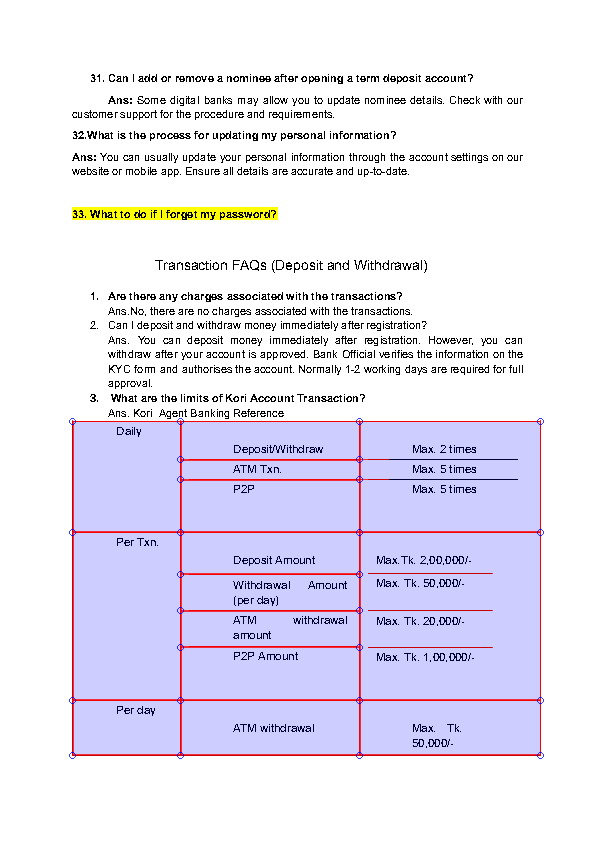

In [40]:
P0 = pdf.pages[29]
im = P0.to_image()

table_settings = {
    "vertical_strategy": "lines_strict",
    "horizontal_strategy": "lines_strict",
    "snap_y_tolerance": 5,
    "intersection_x_tolerance": 15,
}


table = P0.extract_table(table_settings)
text = P0.extract_text_lines(layout=False, strip=True, return_chars=True)
print( text)
if table != None:
    print(convert_to_html_table(table))

im.reset().debug_tablefinder(table_settings)

In [45]:
from unstructured.partition.pdf import partition_pdf

fname = "/home/aiml/workspace/en_bn_rag/docs/FAQ_en.pdf"

elements = partition_pdf(filename=fname,
                         infer_table_structure=True,
                         strategy='hi_res',
                         combine_text_under_n_chars=3000
           )

tables = [el for el in elements if el.category == "Table"]

# print(tables[0].text)
# print(tables[0].metadata.metadata.text_as_html)

In [46]:
print(tables[7].metadata.text_as_html)

<table><thead><tr><th>Mobile Recharge</th><th>100,000</th><th>50</th><th>100,000</th><th></th><th>For ‘Grameenp | hone, Robi, Airtel, Banglalink * mobile recharge, minimum | 20 Tk; Teletalk min recharge 10Tk; (except recharge offer amounts)</th><th>50,000 (For Pre-paid &amp; Skitto mobile | recharge - Max. 1,000 taka recharge is allowed)</th></tr></thead><tbody><tr><td>Remittance</td><td>| 256,250 (Including 2.5% Govt. Incentive)</td><td>15</td><td>1,000,000 | (Including 2.5% Govt. Incentive)</td><td>60</td><td>50</td><td>256,250 (Includin g 2.5% Govt. Incentive )</td></tr><tr><td>Transfer Money</td><td>50,000</td><td>50</td><td>300,000</td><td>100</td><td>10</td><td>50,000</td></tr><tr><td>Add Money | from Bank</td><td>50,000</td><td>25</td><td>300,000</td><td>100</td><td>50</td><td>50000</td></tr></tbody></table>


In [47]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 16,
 "<class 'unstructured.documents.elements.Table'>": 11}

In [48]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

table_elements = [el.metadata.text_as_html for el in raw_pdf_elements if el.category =="Table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

11
16


In [49]:
table_elements

['<table><tr><td>Savings Deposit</td><td>Special Notice Deposit(SND)</td><td>Fixed Deposit</td></tr><tr><td>&lt; 1.00 crore</td><td>1.25</td><td>3 months but&lt;6 months</td><td>| 3.50-8.00</td></tr><tr><td/><td>1.00 crore but &lt;25.00 crore</td><td>1.50</td><td>6 months but&lt;1 year</td><td>| 3.75-8.25</td></tr><tr><td/><td>25.00 crore but &lt;50.00 crore</td><td>1.75</td><td>1 year but&lt;2 years</td><td>4.00-8.25</td></tr><tr><td/><td>50.00 crore but &lt;100.00 crore</td><td>2.00</td><td>2 years but&lt;3 years</td><td>4.00-8.50</td></tr><tr><td>-2.50</td><td>100.00 crore and above</td><td>2.50</td><td>3 years and above</td><td>4.00-8.75</td></tr></table>',
 '<table><tr><td>Particulars</td><td>Charge/Fee Amount</td></tr><tr><td>Charges</td><td>BDT 200.00</td></tr><tr><td>Duty &amp; VAT</td><td>As per Government Rules</td></tr></table>',
 '<table><tr><td/></tr><tr><td/></tr><tr><td/><td/><td/><td/></tr><tr><td/><td/><td/><td/></tr><tr><td/><td/><td/><td/></tr><tr><td/><td/><td/><td/

In [50]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [51]:
# Prompt text
prompt_text = """You are an assistant tasked with summarizing text. \
    When given a question-and-answer passage, your role is to create a concise summary that captures all relevant contextual details from the text. \
    Question-and-answer content: {element}"""
prompt_text = ChatPromptTemplate.from_template(prompt_text)

# Prompt table
prompt_table = """You are an assistant responsible for summarizing tables. \
    When provided with the HTML of a table, your task is to create a concise summary that captures all the information presented in the table. \
    HTML of the table: {element}"""
prompt_table = ChatPromptTemplate.from_template(prompt_table)


# Summary chain
model = ChatOllama(model="llama3.2:3b")
summarize_chain_text = {"element": lambda x: x} | prompt_text | model | StrOutputParser()
summarize_chain_table = {"element": lambda x: x} | prompt_table | model | StrOutputParser()

In [52]:
# Apply to text
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain_text.batch(texts, {"max_concurrency": 5})

In [53]:
# Apply to tables
tables = [i for i in table_elements]
table_summaries = summarize_chain_table.batch(tables, {"max_concurrency": 20})

In [56]:
table_summaries[9]

'Based on the provided HTML table, here is a concise summary:\n\nThe table outlines the limits for various transactions conducted through a service, likely related to mobile banking or financial services.\n\nKey highlights include:\n- Deposit/Withdrawal limits: \n  - Max. 2 times\n  - Max. 5 times (implied daily limit)\n- Specific transaction amounts:\n  - Deposit Amount: Max. Tk. 2,00,000/- per instance\n  - Withdrawal Amount (per day): Max. Tk. 50,000/-\n  - ATM withdrawal amount: Max. Tk. 20,000/-\n  - P2P Amount: Max. Tk. 1,00,000/-\n\nPlease note that the exact ATM withdrawal limit is not specified in the provided table.'

# Add to vectorstore

In [58]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_core.documents import Document

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries", embedding_function=GPT4AllEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()  # <- Can we extend this to images
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [59]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

In [ ]:
from langchain_core.runnables import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Option 1: LLM
model = ChatOllama(model="llama2:13b-chat")
# Option 2: Multi-modal LLM
# model = LLaVA

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)